In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import json
import pandas as pd
import h5py
from tqdm.notebook import tqdm
import collections as cl
import re
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import GroupShuffleSplit, StratifiedGroupKFold

import warnings
warnings.filterwarnings('ignore')

import random
random_state=42
random.seed(random_state)

# load embedding

In [2]:
embedding = 'vggish'
data = h5py.File('embeddings.h5', 'r')

In [3]:
###### IRMAS data ######
dataset = 'irmas'
keys_ori = list(data[dataset][embedding]['keys'])
key_clip = list(set(keys_ori))
len(key_clip)

6705

In [4]:
instruments = [key[key.index('[')+1:key.index(']')] for key in key_clip]
# cl.Counter(instruments)

In [5]:
group_matcher = re.compile(r'.*?\]\[(?P<class>\w+)\]\d.*')

def groupname(x):
    res = re.match(group_matcher, x)
    return res.groups()[0]

genres = [groupname(_) for _ in key_clip]
print(set(genres), len(genres))

{'pop_roc', 'cla', 'jaz_blu', 'lat_sou', 'cou_fol'} 6705


In [6]:
A_genre = ['pop_roc', 'country_folk', 'latin_soul']
B_genre = ['jazz_blue', 'classical']

In [7]:
matcher = re.compile(r'.*?\[(?P<class>\w+)\].*')

def classname(x):
    res = re.match(matcher, x)
    return res.groups()[0]

instruments = [classname(_) for _ in key_clip]
print(set(instruments), len(instruments))

{'org', 'voi', 'pia', 'flu', 'sax', 'gel', 'tru', 'cla', 'cel', 'gac', 'vio'} 6705


In [8]:
instrument_align = {'cla': 'clarinet', 
                   'org': 'organ',
                   'cel': 'cello',
                   'vio': 'violin',
                   'gac': 'guitar-ac',
                   'voi': 'voice',
                   'gel': 'guitar-el',
                   'sax': 'saxophone',
                   'tru': 'trumpet',
                   'pia': 'piano',
                   'flu': 'flute'}

genre_align = {'pop_roc': 'pop_roc',
            'jaz_blu': 'jazz_blue',
            'cla': 'classical',
            'cou_fol': 'country_folk',
            'lat_sou': 'latin_soul'}

In [9]:
# instrument_align = {'cello': 'cel',
#                     'clarinet': 'cla',
#                     'flute': 'flu',
#                     'guitar': ['gac', 'gel'],
#                     'organ': 'org',
#                     'piano': 'pia',
#                     'saxophone': 'sax',
#                     'trumpet': 'tru',
#                     'violin': 'vio',
#                     'voice': 'voi',
#                     }

# genre_align = {'pop_roc': 'pop_roc',
#                 'jazz_blue': 'jaz_blu',
#                 'classical': 'cla',
#                 'country_folk': 'cou_fol',
#                 'latin_soul': 'lat_sou'}

In [10]:
instruments = [instrument_align[key] for key in instruments]
print(set(instruments), len(instruments))

genres = [genre_align[key] for key in genres]
print(set(genres), len(genres))

{'guitar-ac', 'saxophone', 'voice', 'clarinet', 'guitar-el', 'organ', 'flute', 'trumpet', 'cello', 'violin', 'piano'} 6705
{'latin_soul', 'country_folk', 'classical', 'pop_roc', 'jazz_blue'} 6705


In [12]:
encoder_inst = LabelEncoder()
encoder_inst.fit_transform(instruments)   # ori = encoder.inverse_transform(Y)

encoder_genre = LabelEncoder()
encoder_genre.fit_transform(genres)   

instrument_map = dict(zip(encoder_inst.classes_, encoder_inst.transform(encoder_inst.classes_)))
genre_map = dict(zip(encoder_genre.classes_, encoder_genre.transform(encoder_genre.classes_)))

with open("instrument_map.json", "w") as f:
    json.dump(instrument_map, f, default=str)

with open("genre_map.json", "w") as f:

    json.dump(genre_map, f, default=str)

In [13]:
meta_all = pd.DataFrame(columns=['instrument', 'genre', 'file_name'])
meta_all['instrument'] = instruments
meta_all['genre'] = genres
meta_all['file_name'] = key_clip

In [14]:
def train_test_split(meta_all, instrument_map, genre_map, train_ratio):

    train_meta = pd.DataFrame(columns=['instrument', 'genre', 'file_name'])
    test_meta = pd.DataFrame(columns=['instrument', 'genre', 'file_name'])

    for inst in instrument_map:
        for genre in genre_map:

            train_case = pd.DataFrame(columns=['instrument', 'genre', 'file_name'])
            test_case = pd.DataFrame(columns=['instrument', 'genre', 'file_name'])

            to_split = meta_all.loc[(meta_all['instrument'] == inst) & (meta_all['genre'] == genre)]['file_name'].values
            if len(to_split) > 0:
                idx_shuffle = np.array(random.sample(range(len(to_split)), len(to_split)))  # shuffle the idx to select randomly  
                to_split = to_split[idx_shuffle]

                split_idx = int(len(to_split) * train_ratio)
                
                train_case['instrument'] = [inst] * split_idx
                train_case['genre'] = [genre] * split_idx
                train_case['file_name'] = to_split[:split_idx]

                test_case['instrument'] = [inst] * (len(to_split) - split_idx)
                test_case['genre'] = [genre] * (len(to_split) - split_idx)
                test_case['file_name'] = to_split[split_idx:]

                train_meta = train_meta.append(train_case)
                test_meta = test_meta.append(test_case)

    return train_meta, test_meta

In [15]:
def AB_split(meta_all, instrument_map, genre_split):

    meta_split = pd.DataFrame(columns=['instrument', 'genre', 'file_name'])

    for inst in instrument_map:
        for genre in genre_split:

            split_case = pd.DataFrame(columns=['instrument', 'genre', 'file_name'])
            to_split = meta_all.loc[(meta_all['instrument'] == inst) & (meta_all['genre'] == genre)]['file_name'].values

            if len(to_split) > 0:
                idx_shuffle = np.array(random.sample(range(len(to_split)), len(to_split)))  # shuffle
                to_split = to_split[idx_shuffle]
                
                split_case['instrument'] = [inst] * len(to_split)
                split_case['genre'] = [genre] * len(to_split)
                split_case['file_name'] = to_split

                meta_split = meta_split.append(split_case)

    return meta_split

In [16]:
A_meta_all = AB_split(meta_all, instrument_map, A_genre)
B_meta_all = AB_split(meta_all, instrument_map, B_genre)

In [17]:
len(A_meta_all), len(B_meta_all)

(3000, 3705)

In [18]:
A_meta_all = AB_split(meta_all, instrument_map, A_genre)
B_meta_all = AB_split(meta_all, instrument_map, B_genre)
A_meta_all['split'] = ['A'] * len(A_meta_all)
B_meta_all['split'] = ['B'] * len(B_meta_all)

meta_all = A_meta_all.append(B_meta_all)

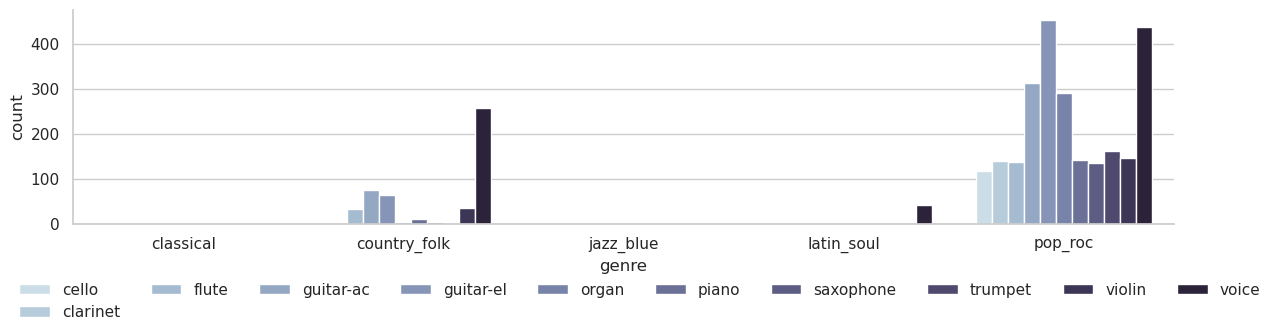

In [19]:
A_meta_count = pd.DataFrame(columns=['instrument', 'genre', 'count'])

for inst in instrument_map:
    for genre in genre_map:
        A_meta_count_item = pd.DataFrame(columns=['instrument', 'genre', 'count'])

        A_meta_count_item['instrument'] = [inst]
        A_meta_count_item['genre'] = [genre]
        A_meta_count_item['count'] = len(A_meta_all.loc[(A_meta_all['instrument'] == inst) & (A_meta_all['genre'] == genre)])

        A_meta_count = A_meta_count.append(A_meta_count_item)

sns.set_theme(context='notebook', style='whitegrid', palette='deep')
ax = sns.catplot(data=A_meta_count, x='genre', y='count', hue='instrument', kind='bar', height=3, aspect=4,
               legend_out=False, palette="ch:s=.25,rot=-.25")
lgd = sns.move_legend(ax, "lower center", bbox_to_anchor=(.54, -.14), ncol=10, title=None, frameon=False)

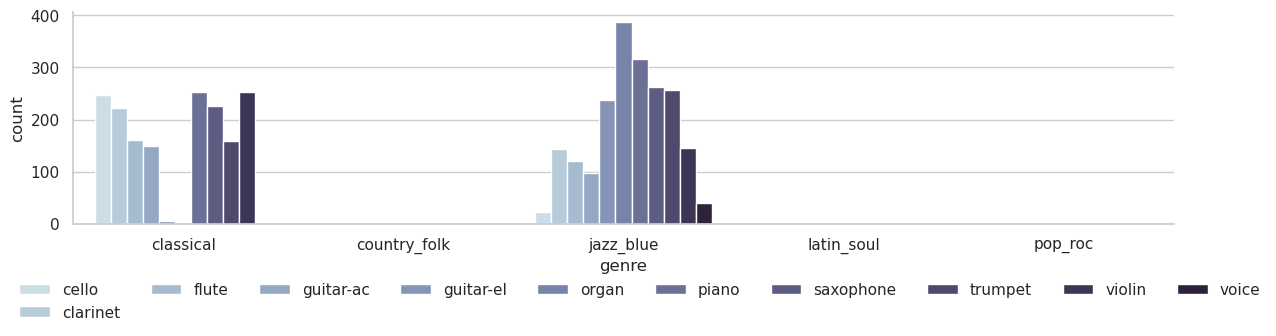

In [20]:
B_meta_count = pd.DataFrame(columns=['instrument', 'genre', 'count'])

for inst in instrument_map:
    for genre in genre_map:
        B_meta_count_item = pd.DataFrame(columns=['instrument', 'genre', 'count'])

        B_meta_count_item['instrument'] = [inst]
        B_meta_count_item['genre'] = [genre]
        B_meta_count_item['count'] = len(B_meta_all.loc[(B_meta_all['instrument'] == inst) & (B_meta_all['genre'] == genre)])

        B_meta_count = B_meta_count.append(B_meta_count_item)

sns.set_theme(context='notebook', style='whitegrid', palette='deep')
ax = sns.catplot(data=B_meta_count, x='genre', y='count', hue='instrument', kind='bar', height=3, aspect=4,
               legend_out=False, palette="ch:s=.25,rot=-.25")
lgd = sns.move_legend(ax, "lower center", bbox_to_anchor=(.54, -.14), ncol=10, title=None, frameon=False)

In [21]:
meta_all.to_csv('irmas_meta_all.csv', header=None, index=None)

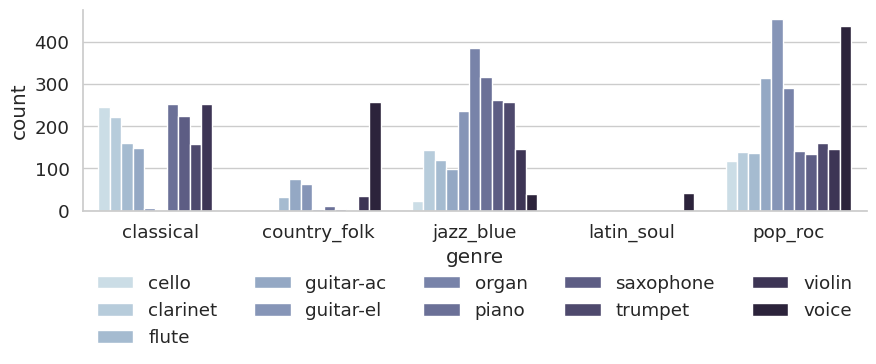

In [46]:
meta_all_count = pd.DataFrame(columns=['instrument', 'genre', 'count'])

for inst in instrument_map:
    for genre in genre_map:
        meta_all_count_item = pd.DataFrame(columns=['instrument', 'genre', 'count'])

        meta_all_count_item['instrument'] = [inst]
        meta_all_count_item['genre'] = [genre]
        meta_all_count_item['count'] = len(meta_all.loc[(meta_all['instrument'] == inst) & (meta_all['genre'] == genre)])

        meta_all_count = meta_all_count.append(meta_all_count_item)

plt.rcParams['figure.constrained_layout.use'] = True
sns.set_theme(context='notebook', style='whitegrid', palette='deep', font_scale=1.2)
ax = sns.catplot(data=meta_all_count, x='genre', y='count', hue='instrument', kind='bar', height=3, aspect=3,
               legend_out=False, palette="ch:s=.25,rot=-.25")
lgd = sns.move_legend(ax, "lower center", bbox_to_anchor=(.54, -.25), ncol=5, title=None, frameon=False)
plt.savefig('results/genre_distribution_ori_all.pdf', bbox_inches='tight')

# A split

In [23]:
A_train, A_test = train_test_split(A_meta_all, instrument_map, genre_map, 0.75)
A_train['split'] = ['train'] * len(A_train)
A_test['split'] = ['test'] * len(A_test)
A_meta = A_train.append(A_test)

In [24]:
B_train, B_test = train_test_split(B_meta_all, instrument_map, genre_map, 0.75)
B_train['split'] = ['train'] * len(B_train)
B_test['split'] = ['test'] * len(B_test)
B_meta = B_train.append(B_test)

In [25]:
A_meta.to_csv('A_meta.csv', index=None)

In [26]:
B_meta.to_csv('B_meta.csv', index=None)